- differences between classification report and graph accuracy metrics

In [ ]:
# Google Drive stuff
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# tf
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


- libraries

In [ ]:
%tensorflow_version 2.x
# batch ingestion of pics without pickle
from tensorflow.keras.preprocessing import image_dataset_from_directory

# nns
from tensorflow.keras.applications import VGG16, VGG19,Xception, InceptionResNetV2, DenseNet121, ResNet50 

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import layers # for data augmentation
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten # Input, Conv2D, 
#from tensorflow.keras.layers import Layer

# optimization
from tensorflow.keras.optimizers import Adam #, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy, categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping

# metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_precision_recall_curve
from itertools import chain # to flatten the real labels array from validation set
import json # to save in a file metrics
#from datetime import datetime # to name results

# viz & arrays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

- paths

In [ ]:
# paths i'll use
base_folder = "/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/"
input_folder = base_folder+"input/" #for pickling data
input = input_folder+"House_Room_Dataset-5_rooms" # for requesting directly pics
src_folder =  base_folder+"src/"
output_folder = base_folder + "/output/"

# insert the directory for using my functions in this notebook
import sys
sys.path.insert(0,"/content/drive/My Drive/2-Estudios/viu-master_ai/tfm-deep_vision/src/")

- libraries

In [ ]:
def generic_last_2layers(data_augmentation, nn,neurons_final_layer:int,  dropout_layers: bool, dropout_position: str =="first", dropout_percent: float):
  '''
  Xception, InceptionResNetV2, DenseNet121 have different architecture, but all of them have the same top model. So we add the data augmentation layer,
  load the functional model and add the top model with/without dropout in first/middle position
  works with pre-trained models (Xception, InceptionResNetV2, DenseNet121) for transfer-learning. 
  top layer consisting of 2 layers: globalaverage2d layer and predictions layer.
  - nn                  = pre-trained model without top model
  - neurons_final_layer = how many classes we want to work with
  - dropout_layers      = bool. dropout in the top model (True/False)
  - dropout_position    = dropout layer before top model or between dense layers (first/middle)
  - dropout_percent     = (0,1). float
  EX: generic_last_2layers(Xception(include_top=False, 
                                    weights='imagenet', 
                                    input_shape=(128, 128, 3), 
                                    classes = num_classes, 
                                    classifier_activation='softmax'
                                    ), 
                          5, True, "first", 0.2
                          )
  '''
  pre_trained = Sequential()

  if data_augmentation:
    #data augmentation
    pre_trained.add(data_augmentation)
    pre_trained.add(layers.Rescaling(1./255))

  pre_trained.add(nn)

  # Freeze the layers 
  for layer in pre_trained.layers:
      layer.trainable = False

  #adding top model with/without dropout
  if dropout_layers is True:
      if dropout_position=="first":
          pre_trained.add(layers.Dropout(dropout_percent)) 
          pre_trained.add(layers.GlobalAveragePooling2D()) # https://keras.io/api/layers/pooling_layers/global_average_pooling2d/
          

      elif dropout_position == "middle":
          pre_trained.add(layers.GlobalAveragePooling2D()) 
          pre_trained.add(layers.Dropout(dropout_percent)) 
      
  else:
    pre_trained.add(layers.GlobalAveragePooling2D())
  
  # last layer
  pre_trained.add(layers.Dense(neurons_final_layer,activation=('softmax')))
  return pre_trained

- batch processing data augmentation

In [ ]:
image_size = (128,128)
batch_size = 128 # 32

In [ ]:
# train set
# https://www.tensorflow.org/tutorials/images/classification
train_ds = image_dataset_from_directory(
    input,
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    # labels='inferred',
    # label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size= image_size,
    batch_size= batch_size,
    color_mode='rgb',
    #shuffle=False 
)

Found 5250 files belonging to 5 classes.
Using 4200 files for training.


In [ ]:
# validation set (use the same seed and split)
val_ds = image_dataset_from_directory( # utilizar el de validación como test
    input,
    # labels='inferred',
    # label_mode='categorical',
    class_names=["Bedroom","Bathroom","Dinning","Livingroom","Kitchen"],
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    color_mode='rgb',
    shuffle=False 
)

Found 5250 files belonging to 5 classes.
Using 2625 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['Bedroom', 'Bathroom', 'Dinning', 'Livingroom', 'Kitchen']

- data augmentation

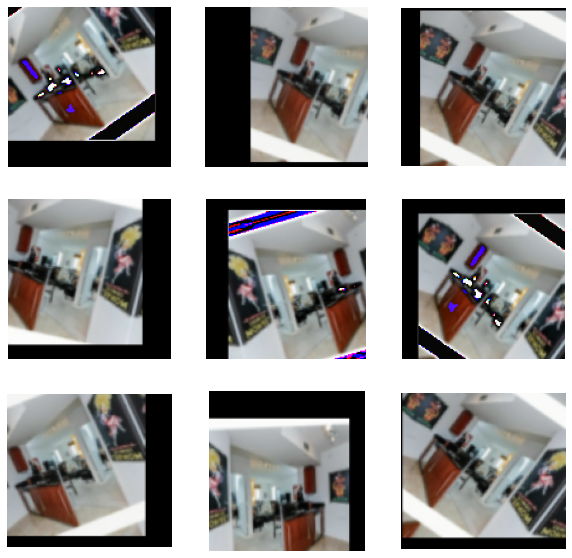

In [ ]:
# https://www.tensorflow.org/guide/keras/preprocessing_layers
data_augmentation = Sequential(  
  [
    layers.RandomFlip("horizontal",input_shape=(image_size[0],image_size[1],3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.005),
    #random_invert(0.2),  # color inversion
    layers.RandomContrast(0.1),
    #Contrast(),
    #layers.RandomCrop(image_size[0],image_size[1]), 
    layers.RandomWidth(0.05, interpolation="gaussian"),
    layers.RandomHeight(0.05),
    layers.RandomTranslation((-0.2,0.3),(-0.2,0.3), fill_mode='constant',interpolation='bilinear', seed=None, fill_value=0.0),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

- model & callback

In [ ]:
base_model_densenet121 = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3), classes = 5) # has no classifier activation args
densenet_middle_drop = generic_last_2layers(data_augmentation, nn=base_model_densenet121, neurons_final_layer=5, dropout_layers=True,  dropout_position="middle", dropout_percent = 0.2)

callbacks = [
    EarlyStopping(
        # Stop training when the metric is no longer improving
        monitor="val_accuracy", mode="max", #  "val_loss",
        # "no longer improving" being defined as "no better than 1e-4 less"
        min_delta=1e-4,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1
    )
]
densenet_middle_drop.summary()

- fitting & compiling

In [ ]:
epochs = 50

In [ ]:
# train the model
# densenet_middle_drop.compile( optimizer = "adam", 
#                 loss=SparseCategoricalCrossentropy(from_logits=True) ,#'categorical_crossentropy', 
#                 metrics=['accuracy'] # "recall"
#                 )
# history = densenet_middle_drop.fit(train_ds, validation_data=val_ds, 
#                                     epochs=epochs,
#                                     #callbacks = callbacks
#                                     )

In [ ]:
# number_of_epochs_it_ran = len(history.history['loss']) 
# print("run epochs: ",number_of_epochs_it_ran)

run epochs:  50


In [ ]:
# # saving model
# name = "densenet121_dataAug_dropoutMid02"
# densenet_middle_drop.save(output_folder+name+".h5")

- plotting model

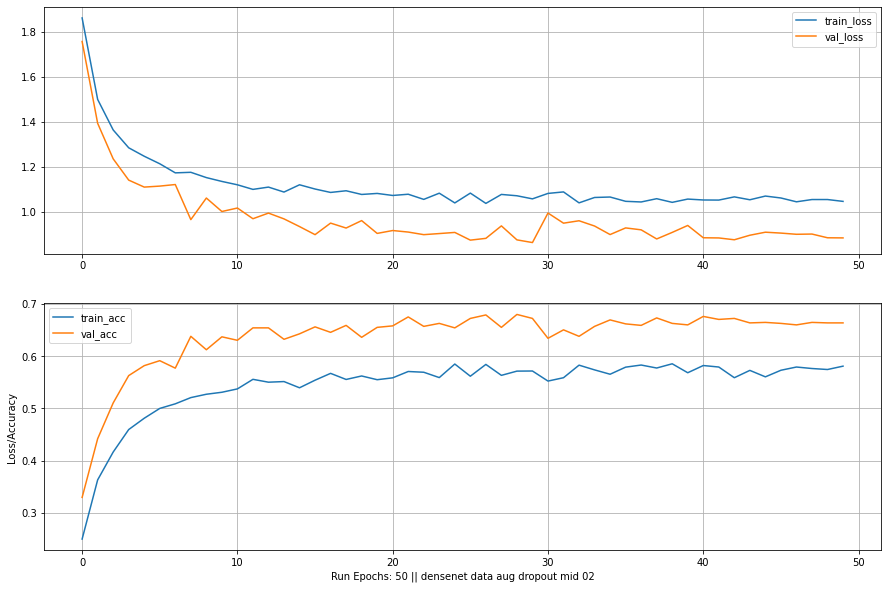

In [ ]:
#Plotting the training and validation loss and accuracy

f,ax=plt.subplots(2, 1, figsize=(15,10))
#Loss
ax[0].plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
ax[0].plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
ax[0].grid(visible=True, which="both", axis='both')
ax[0].legend()

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
#Accuracy
ax[1].plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
ax[1].plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
ax[1].grid(visible=True, which="both", axis='both')
ax[1].legend()

plt.xlabel("Run Epochs: "+str(epochs)+" || densenet data aug dropout mid 02")
plt.ylabel("Loss/Accuracy")
plt.show()

- evaluation

In [ ]:
  # saving model metrics to json
  evaluation = densenet_middle_drop.evaluate(val_ds, batch_size=batch_size, return_dict=True)
  evaluation

9/9 [==============================] - 3s 77ms/step - loss: 0.8834 - accuracy: 0.6638


{'accuracy': 0.6638095378875732, 'loss': 0.8834436535835266}

- inferences

In [ ]:
  # get inferences
  y_pred_float = densenet_middle_drop.predict(val_ds)
  y_pred = np.argmax(y_pred_float, axis=1) 
  for x,y in zip(y_pred_float, y_pred):
    print(x,y)

- classification report

In [ ]:
# transform tf array into multiple arrays
numeric_values_val = list(val_ds.map(lambda x, y: y))
# transform into a single array of arrays
y_target=[]
y_target = [y_target.append(arr) or arr for arr in numeric_values_val]
# create a single list
y_target = list(chain.from_iterable(y_target))
# transform the list to a np array
y_target = np.array(y_target)
print(y_target)
print(len(y_target))

[2 2 2 ... 4 0 4]
1050


In [ ]:
print(classification_report(y_pred , y_target), target_names=class_names))

              precision    recall  f1-score   support

           0       0.31      0.23      0.26       327
           1       0.10      0.12      0.11        85
           2       0.24      0.23      0.23       260
           3       0.19      0.27      0.22       186
           4       0.21      0.22      0.21       192

    accuracy                           0.22      1050
   macro avg       0.21      0.21      0.21      1050
weighted avg       0.24      0.22      0.23      1050



the problem is the following:

- i'm using the method **image_dataset_from_directory*, which by default, is set with shuffle = True. That rearranges pics so afther shuffling, real labels are not related with their associated arrays (pics).
- Then, I have to set **shuffle = False**, nevertheless it's taking pics in order and diving them into train and validation set. This is terrible because in this way, the validation set has only 2 of 5 classes and train, 3 of 5.
- right now i have 5 folders of pics: Each folder contain a single class.

#### Next approach:


- To make just 2 folders: train folder and validation folder. They must contain a shuffled portion of the whole.
- Then, when calling **image_dataset_from_directory**, **do not** split it into train in validation, but calling different folders (the train folder and the validation folder).
- Use the *sklearn.model_selection.train_test_split* with *stratify* parameter for labels to create an heterogeneous split.

# working with saved model

In [ ]:
densenet121 = load_model(output_folder+"densenet121_dataAug_dropoutMid02.h5")
evaluation  = densenet121.evaluate(val_ds, batch_size=batch_size, return_dict=True)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


9/9 [==============================] - 8s 306ms/step - loss: 1.2338 - accuracy: 0.4638


In [ ]:
# transform tf array into multiple arrays
numeric_values_val = list(val_ds.map(lambda x, y: y))
# transform into a single array of arrays
y_target=[]
y_target = [y_target.append(arr) or arr for arr in numeric_values_val]
# create a single list
y_target = list(chain.from_iterable(y_target))
# transform the list to a np array
y_target = np.array(y_target)
print(len(y_target), y_target)

2625 [2 2 2 ... 3 3 3]


In [ ]:
set(y_target)

{2, 3, 4}

In [ ]:
# get inferences
y_pred_float = densenet121.predict(val_ds)
y_pred = np.argmax(y_pred_float, axis=1) 
print(len(y_pred), y_pred)

1050 [2 3 1 ... 2 0 3]


In [ ]:
# for x,y in zip(y_target, y_pred):
#   print(x,y)

In [ ]:
# meter esto 
# pred = [1 * (x[0]>=0.5) for x in preds_sigmoid]
# https://stackoverflow.com/questions/66356195/confusion-matrix-giving-bad-results-but-validation-accuracy-95

In [ ]:
print(classification_report(y_pred , y_target, target_names=class_names))